In [44]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

def knearestneighbors(df, k, attributes, target_var='disease', target_indicator=1):

    # Select features and target
    X = df[attributes].values
    y = df[target_var].values
    
    # Initialize Nearest Neighbors model
    nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

    # Track precision, recall, and F1 scores for 10 iterations
    test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.33, 0.4, 0.45, 0.2, 0.25]
    precision_scores = []
    recall_scores = []
    f1_scores = []
    
    for _ in range(10):  # 10 iterations
        # Randomly choose a test size and perform train-test split
        test_size = random.choice(test_sizes)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Fit the Nearest Neighbors model on the training set
        nn.fit(X_train)

        # Store predictions for the test set
        y_pred = []
        for test_point in X_test:
            distances, indices = nn.kneighbors([test_point])
            nbrs = df.iloc[indices[0]]

            # Get the majority class among the k-nearest neighbors
            healthy = nbrs[nbrs[target_var] == 0].count()[target_var]
            sick = nbrs[nbrs[target_var] == 1].count()[target_var]
            predict = 0 if (healthy > sick) else 1
            y_pred.append(predict)

        # Evaluate the predictions: precision, recall, F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', labels=[target_indicator])
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)


    for i, precision in enumerate(precision_scores):
        print(f"Iteration: {i + 1}")  # Start iteration count from 1 instead of 0
        print(f"Precision Score: {precision_scores[i]}")
        print(f"Recall Score: {recall_scores[i]}")
        print(f"F1 Score: {f1_scores[i]}")
        print()
    print("Mean F1 Score:", sum(f1_scores) / len(f1_scores))


## Part I

First, we determined (through manual testing) that the best attributes to use for our predictions are age, trestbps (resting blood pressure), chol (serum cholestoral), and thalach (maximum heart rate). We made sure to standardize these columns.

In [45]:
df = pd.read_csv('cleveland.csv')
df = df.rename({'num': 'disease'}, axis=1)
df['disease'] = df['disease'].apply(lambda x: min(x, 1))
columns_to_standardize = ['age', 'trestbps', 'chol', 'thalach']
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

Next, we can determine the optimal value of k for this dataset. We did this using the elbow method.

In [46]:
def get_scores(k, input_df, attributes, target_var, target_indicator):
  # Use knn on age. First create a nearest neighbors object.
  nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

  # This builds an index data structure under the hood for query performance
  X = input_df[attributes].values
  fit = nn.fit(X)

  # Get random patients to test on
  n = 50
  patients = input_df.sample(n)
  patientsX = patients[attributes].values
  patientsy = patients[[target_var]].values
  # display(patients)

  # Find the k nearest neighbors to the patient.
  distances, indices = fit.kneighbors(patientsX)

  y_pred = []
  for i in range(n):
      nbrs = input_df.iloc[indices[i]]
      # Drop the patient of interest
      nbrs = nbrs.drop(patients.index[i], errors='ignore')

      healthy = nbrs[nbrs[target_var] == 0].count()[target_var]
      sick = nbrs[nbrs[target_var] == 1].count()[target_var]
      predict = 0 if (healthy > sick) else 1
      y_pred.append(predict)

  return precision_recall_fscore_support(patientsy, y_pred, labels=[target_indicator])

def determine_k(input_df, attributes, target_var='disease', target_indicator=1):

  kvals = range(2, 250, 3)
  scores = [get_scores(k, input_df, attributes, target_var, target_indicator) for k in kvals]
  scores = [(p[0], r[0], f[0], s[0]) for (p,r,f,s) in scores]
  scores = list(zip(*scores))

  k_options = pd.DataFrame(
    {'f score': scores[2],
     'k': kvals
    })

  k_options = k_options.sort_values(by='f score', ascending=False)

  return (kvals, scores[2], k_options)

We'll use the elbow method to determine the optimal k in the graph below. While are results are not as clear as would be ideal, we see the "elbow bend" point at around k = 10. We'll use this value as k in our calculations.

Text(0, 0.5, 'f score')

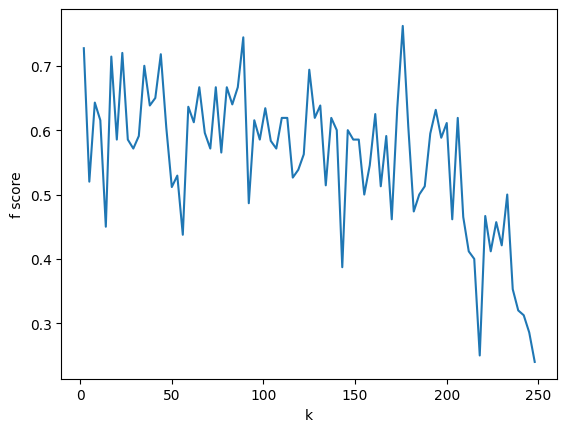

In [47]:
result = determine_k(df, ['age', 'trestbps', 'chol', 'thalach'])
plt.plot(result[0], result[1])
plt.xlabel('k')
plt.ylabel('f score')

Now that we've determined the optimal k and set of attributes, we can use the k nearest neighbors method to predict whether patients have heart disease. We'll also evaluate our model.

In [48]:
knearestneighbors(df, 10, ['age', 'trestbps', 'chol', 'thalach'])

Iteration: 1
Precision Score: 0.46296296296296297
Recall Score: 0.5102040816326531
F1 Score: 0.4854368932038835

Iteration: 2
Precision Score: 0.5833333333333334
Recall Score: 0.5675675675675675
F1 Score: 0.5753424657534246

Iteration: 3
Precision Score: 0.4838709677419355
Recall Score: 0.5172413793103449
F1 Score: 0.5

Iteration: 4
Precision Score: 0.5
Recall Score: 0.40625
F1 Score: 0.4482758620689655

Iteration: 5
Precision Score: 0.5
Recall Score: 0.3333333333333333
F1 Score: 0.4

Iteration: 6
Precision Score: 0.5833333333333334
Recall Score: 0.5675675675675675
F1 Score: 0.5753424657534246

Iteration: 7
Precision Score: 0.5833333333333334
Recall Score: 0.5675675675675675
F1 Score: 0.5753424657534246

Iteration: 8
Precision Score: 0.5
Recall Score: 0.3333333333333333
F1 Score: 0.4

Iteration: 9
Precision Score: 0.5
Recall Score: 0.3333333333333333
F1 Score: 0.4

Iteration: 10
Precision Score: 0.5942028985507246
Recall Score: 0.640625
F1 Score: 0.6165413533834586

Mean F1 Score: 0.49

## Part II

Now, we will repeat the same process for our second data set. This data set contains information about urls and whether they are known to be phishing or legitimate. 

Source: https://archive.ics.uci.edu/dataset/967/phiusiil+phishing+url+dataset

First, we determined (through manual testing) that the best attributes to use for our predictions are URLSimilarityIndex, HasCopyrightInfo, NoOfJS, NoOfExternalRef, and URLLength. We made sure to standardize these columns.

In [49]:
phishing_df = pd.read_csv('phishing.csv')
phishing_df = phishing_df.head(1000)

columns_to_standardize = ['URLSimilarityIndex', 'HasCopyrightInfo', 'NoOfJS', 'NoOfExternalRef', 'URLLength']
scaler = StandardScaler()
phishing_df[columns_to_standardize] = scaler.fit_transform(phishing_df[columns_to_standardize])

Next, we can determine the optimal value of k for this dataset. We did this using the elbow method.

While are results are not as clear as would be ideal, in the graph below, we see the "elbow bend" point at around k = 150. We'll use this value as k in our calculations.

Text(0, 0.5, 'f score')

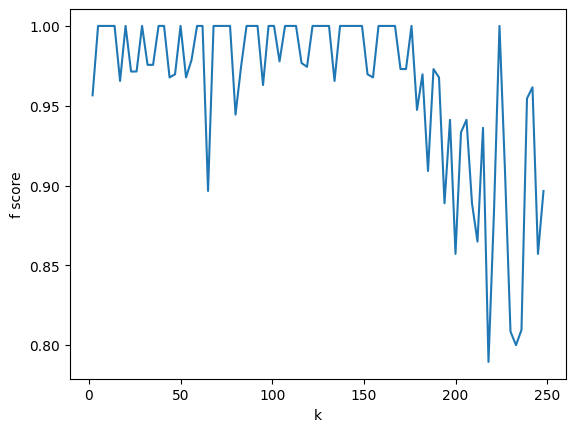

In [50]:
result = determine_k(phishing_df, ['URLSimilarityIndex', 'HasCopyrightInfo', 'NoOfJS', 'NoOfExternalRef', 'URLLength'], 'label', 0)
plt.plot(result[0], result[1])
plt.xlabel('k')
plt.ylabel('f score')

Now that we've determined the optimal k and set of attributes, we can use the k nearest neighbors method to predict whether a url is legitimate or a phishing attempt. We'll also evaluate our model.

In [51]:
knearestneighbors(phishing_df, 150, ['URLSimilarityIndex', 'HasCopyrightInfo', 'NoOfJS', 'NoOfExternalRef', 'URLLength'], 'label', 0)

Iteration: 1
Precision Score: 0.61
Recall Score: 1.0
F1 Score: 0.7577639751552795

Iteration: 2
Precision Score: 0.66
Recall Score: 1.0
F1 Score: 0.7951807228915663

Iteration: 3
Precision Score: 0.62
Recall Score: 1.0
F1 Score: 0.7654320987654321

Iteration: 4
Precision Score: 0.6366666666666667
Recall Score: 1.0
F1 Score: 0.7780040733197556

Iteration: 5
Precision Score: 0.6366666666666667
Recall Score: 1.0
F1 Score: 0.7780040733197556

Iteration: 6
Precision Score: 0.62
Recall Score: 1.0
F1 Score: 0.7654320987654321

Iteration: 7
Precision Score: 0.61
Recall Score: 1.0
F1 Score: 0.7577639751552795

Iteration: 8
Precision Score: 0.62
Recall Score: 1.0
F1 Score: 0.7654320987654321

Iteration: 9
Precision Score: 0.62
Recall Score: 1.0
F1 Score: 0.7654320987654321

Iteration: 10
Precision Score: 0.62
Recall Score: 1.0
F1 Score: 0.7654320987654321

Mean F1 Score: 0.7693877313668798
